In [1]:
def UNet_Slice(slice_unet) : 
    import logging
    import os
    import sys
    import tempfile
    from glob import glob

    import torch
    from PIL import Image
    from torch.utils.tensorboard import SummaryWriter

    import monai
    from monai.data import create_test_image_2d, list_data_collate, decollate_batch, DataLoader
    from monai.inferers import sliding_window_inference
    from monai.metrics import DiceMetric
    from monai.networks.nets import UNet

    from monai.transforms import (
        Activations,
        EnsureChannelFirstd,
        AsDiscrete,
        Compose,
        LoadImaged,
        RandCropByPosNegLabeld,
        RandRotate90d,
        ScaleIntensityd, 
        SaveImage
    )

    from monai.visualize import plot_2d_or_3d_image

    import cv2
    import numpy as np
    import nibabel as nib
    import matplotlib.pyplot as plt
    
    images = [slice_unet]

    list_results = list()
    list_dice = list()
    list_images = list()

    val_files = [{"img": img, "seg": img} for img in images]

    # define transforms for image and segmentation
    val_transforms = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            EnsureChannelFirstd(keys=["img", "seg"]),
        ]
    )
    val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
    # sliding window inference need to input 1 image in every iteration
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=0, collate_fn=list_data_collate)
    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
    post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
    saver = SaveImage(output_dir="./output", output_ext=".png", output_postfix="seg")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

    model.load_state_dict(torch.load("best_metric_model_segmentation2d_dict.pth"))

    for val_data in val_loader : 
        val_images, val_labels = val_data["img"].to(device), val_data["seg"].to(device)
        roi_size = (512, 512)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        val_labels = decollate_batch(val_labels)
        list_results.append(val_outputs[0][0].cpu().numpy())
        list_images.append(val_data["img"])
        
    return val_outputs[0][0].cpu().numpy() * val_data["img"]


def classic_seg(slice_classic) : 
    from PIL import Image
    from skimage.morphology import disk, closing
    thresholded = np.copy(slice_classic)
    thresholded[slice_classic>90] =1
    thresholded[slice_classic<=90] = 0
    footprint = disk(20)
    closed = closing(thresholded, footprint)
    return closed
    

In [69]:
from skimage import io 
import numpy as np
import glob
import nibabel as nib
from tqdm.auto import tqdm
from PIL import Image

original_volume = io.imread("Bank 1_035.tif")
segmented_volume = np.zeros((900,512,512))
counter = 0 
for i in tqdm(range(0,900)) : 
    slice_int = original_volume[i, :, :]
    slice_seg = classic_seg(slice_int)
    slice_seg = np.resize(slice_seg, (512,512))
    if len(np.unique(slice_seg)) == 2 and np.unique(slice_seg, return_counts= True)[1][1] > 100 : 
        im = Image.fromarray(slice_int)
        im = im.resize((512,512))
        im.save(str(i) + ".png")
    else : 
        segmented_volume[i,:,:] = slice_seg 


png_files = glob.glob("*.png")
for element in png_files : 
    slice_number = element.replace(".png", "")
    slice_segunet = UNet_Slice(element)
    print(slice_segunet.shape)
    segmented_volume[int(slice_number), :, :] = slice_segunet[0,0,:,:].T
volume = nib.Nifti1Image(segmented_volume.astype(np.uint8), affine=np.eye(4))
nib.save(volume, "035_volume_unet2_final.nii.gz")

  0%|          | 0/900 [00:00<?, ?it/s]

(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 512)
(1, 1, 512, 51

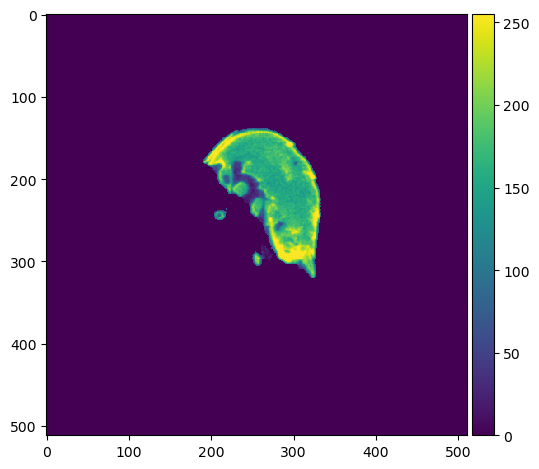

In [65]:
io.imshow(segmented_volume[400,:,:])

In [51]:
png_files = glob.glob("*.png")
for element in png_files : 
    slice_number = element.replace(".png", "")
    slice_segunet = UNet_Slice(element)
    segmented_volume[int(slice_number), :, :] = slice_segunet[:,:,0,0].T
volume = nib.Nifti1Image(segmented_volume, affine=np.eye(4))

In [66]:
volume = nib.Nifti1Image(segmented_volume.astype(np.uint8), affine=np.eye(4))

In [67]:
nib.save(volume, "012_volume_unet2_final.nii.gz")

In [17]:
volume = nib.Nifti1Image(segmented_volume, affine=np.eye(4))
nib.save(volume, "012_volume_unet2.nii.gz")

KeyboardInterrupt: 

In [49]:
prueba = nib.Nifti1Image(segmented_volume.astype(np.uint8), affine=np.eye(4))
nib.save(prueba, "unet_volume.nii.gz")

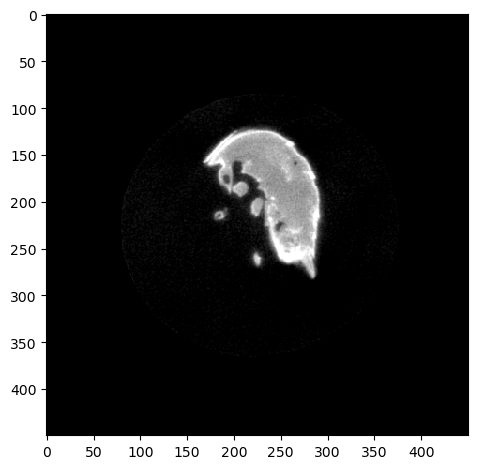

In [39]:
io.imshow(original_volume[400,:,:])

In [47]:
original_volume.dtype

dtype('uint8')

In [48]:
segmented_volume.dtype

dtype('float64')

In [25]:
import tifffile
tifffile.imwrite("output.tif", segmented_volume)

In [28]:
prueba = segmented_volume.astype(float)

In [34]:
prueba[100,:,:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
np.unique(slice_seg, return_counts= True)[1][1]

1